## Setup

In [229]:
from functions import Model, get99, splitData, dropMissingValues, z_score, outliers_knn, outliers_dbscan, getNoise, getRelFeatures, train_test_split, getCombinations, get_unique_list, bold, blue, red, green, getBestModel, np_to_df, df_to_np, drop99_all, z_score_individual, train_test_to_df, saveModel, loadModel
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
import warnings
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
warnings.filterwarnings('ignore')

Json Hyper Parameters

In [230]:
f = open ('data/json/input.json', "r")
PARAMETERS = json.loads(f.read())

#General parameter
#PARAMETERS = PARAMETERS_ALL["GRID_SEARCH"]
SPLIT_SIZE = PARAMETERS["SPLIT_SIZE"]

#Outlier / Noise
OUTLIER99 = PARAMETERS["OUTLIER99"] 
OUTLIER_ZSCORE = {"STD" : PARAMETERS["OUTLIER_ZSCORE"]["STD"]}
OUTLIER_ZSCORE_IND = PARAMETERS["OUTLIER_ZSCORE_IND"]
OUTLIER_KNN = {"K": PARAMETERS["OUTLIER_KNN"]["K"], "X": PARAMETERS["OUTLIER_KNN"]["X"]}
OUTLIER_DBSCAN = {"K": PARAMETERS["OUTLIER_DBSCAN"]["K"], "X": PARAMETERS["OUTLIER_DBSCAN"]["X"], "EPS": PARAMETERS["OUTLIER_DBSCAN"]["EPS"], "MIN_SAMPLES":  PARAMETERS["OUTLIER_DBSCAN"]["MIN_SAMPLES"]}
OUTLIER_NOISE = {"CV": PARAMETERS["OUTLIER_NOISE"]["CV"], "DEPTH": PARAMETERS["OUTLIER_NOISE"]["DEPTH"], "MULTI": PARAMETERS["OUTLIER_NOISE"]["MULTI"] }

#Feature Selection
FEATURE_SEL_CORR = {"THRESHOLD_CORR": PARAMETERS["FEATURE_SEL_CORR"]["THRESHOLD"]}
FEATURE_SEL_MANUAL = PARAMETERS["FEATURE_SEL_MANUAL"]

#Algorythm Selection
REG_LINEAR = PARAMETERS["REG_LINEAR"]
REG_GRADIANT = PARAMETERS["REG_GRADIANT"]
REG_RIDGE = PARAMETERS["REG_RIDGE"]
REG_TREE = PARAMETERS["REG_TREE"]
REG_LASSO = {"ALPHA": PARAMETERS["REG_LASSO"]["ALPHA"]}

f.close()

Get Data from CSV

In [231]:
#Get raw Data
df = pd.read_csv("data/csv/house_data_training.csv", sep=';') 
# remove unnamed column
df = df.iloc[:, 1:]
#Transform string to datetime
df["date"] = pd.to_datetime(df["date"])

Missing Values

In [232]:
df = dropMissingValues(df) 

In [233]:
if OUTLIER99 == True:
    print("outlier_99")
    outlier_list_99 = get99(df)
    df = drop99_all(df, outlier_list_99 )
    print(green('done'), "\n")

outlier_99
done 



## Baseline Regression model

In [234]:
import matplotlib.pyplot as plt

X, y = df.drop(columns=["price", "date"]), df["price"]
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size = SPLIT_SIZE, random_state=1)

reg_base = LinearRegression()
reg_base.fit(X_train_base, y_train_base)

# evaluate the model
ypred_base = reg_base.predict(X_test_base)

# evaluate predictions
mae_base = mean_absolute_error(y_test_base, ypred_base)
print(f'MAE for Baseline Regressionmodel: {blue(np.round(mae_base, 2))}')

MAE for Baseline Regressionmodel: 128810.75


## Outlier Detection

In [235]:
outlier_dict_all = {}

print('starting z_score')
for p in OUTLIER_ZSCORE["STD"]:
    print(p)
    outlier_list_z_score = z_score(df, p)
    outlier_dict_all["z_score_"+str(p)] = outlier_list_z_score

if OUTLIER_ZSCORE_IND == True:
    outlier_list_z_score_ind = z_score_individual(df)

print(green('done'), '\n\nstarting knn')
for k in OUTLIER_KNN["K"]:
    for o in OUTLIER_KNN["X"]:
        print(k, o)
        outlier_list_knn = outliers_knn(df, k, o, SPLIT_SIZE)
        outlier_dict_all["knn_"+str(k)+"_"+str(o)] = outlier_list_knn

print(green('done'), '\n\nstarting db_scan')
for k in OUTLIER_DBSCAN["K"]:
    for o in OUTLIER_DBSCAN["X"]:
        for e in OUTLIER_DBSCAN["EPS"]:
            for m in OUTLIER_DBSCAN["MIN_SAMPLES"]:
                print(k, o, e, m)
                outlier_list_dbscan = outliers_dbscan(df, k, o, e, m, SPLIT_SIZE)
                outlier_dict_all["db_scan_"+str(k)+"_"+str(o)+"_"+str(e)+"_"+str(m)] = outlier_list_dbscan

print(green('done'), '\n\nstarting noise')
for cv in OUTLIER_NOISE["CV"]:
    for d in OUTLIER_NOISE["DEPTH"]:
        for m in OUTLIER_NOISE["MULTI"]:
            print(cv, d, m)
            outlier_list_noise = getNoise(df, cv, d, m)
            outlier_dict_all["noise_"+str(cv)+"_"+str(d)+"_"+str(m)] = outlier_list_noise

print(green('done'))

starting z_score
10.1
done 

starting knn
3 1500
done 

starting db_scan
3 1500 0.4 8
done 

starting noise
5 5 10
done


## Combinations Outlier / Noise 

In [236]:
outlier_lists_all = list(outlier_dict_all.values())
outlier_lists_keys = list(outlier_dict_all.keys())
combination_list = []
for i, combo in enumerate(getCombinations(outlier_lists_keys), 1):
    if not i == 1: #emtpy tuple
        combination_list.append(combo)
        # print('combo #{}: {}'.format(i, combo))
print("...")
for c in combination_list[10:]:
    print(bold("Combination: "), blue(c),"\n",)
print(bold(len(combination_list)), " total Combinations")

...
Combination:  ('z_score_10.1', 'knn_3_1500', 'db_scan_3_1500_0.4_8') 

Combination:  ('z_score_10.1', 'knn_3_1500', 'noise_5_5_10') 

Combination:  ('z_score_10.1', 'db_scan_3_1500_0.4_8', 'noise_5_5_10') 

Combination:  ('knn_3_1500', 'db_scan_3_1500_0.4_8', 'noise_5_5_10') 

Combination:  ('z_score_10.1', 'knn_3_1500', 'db_scan_3_1500_0.4_8', 'noise_5_5_10') 

15  total Combinations


## Algorythm Selection

### Linear Regression

In [237]:
model_obj_list = []

In [238]:
if REG_LINEAR == True:
    for i, c in enumerate(combination_list):
        print(f'\n{bold(i)}: {blue(c)}')
        outlier_list = get_unique_list(outlier_dict_all, c)
        try: 
            X_train, X_test, y_train, y_test = splitData(df, SPLIT_SIZE, outlier_list, "drop") #TODO drop entfernen
            model = LinearRegression()
            obj = Model(model, (X_train, X_test, y_train, y_test), c, df, df.columns.to_list())
            model_obj_list.append(obj)

        except Exception as e:
            print(bold("Error"), red(e))


0: ('z_score_10.1',)
dropped 41 rows

1: ('knn_3_1500',)
dropped 1500 rows

2: ('db_scan_3_1500_0.4_8',)
dropped 3783 rows

3: ('noise_5_5_10',)
dropped 35 rows

4: ('z_score_10.1', 'knn_3_1500')
dropped 1536 rows

5: ('z_score_10.1', 'db_scan_3_1500_0.4_8')
dropped 3814 rows

6: ('z_score_10.1', 'noise_5_5_10')
dropped 76 rows

7: ('knn_3_1500', 'db_scan_3_1500_0.4_8')
dropped 3783 rows

8: ('knn_3_1500', 'noise_5_5_10')
dropped 1532 rows

9: ('db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3808 rows

10: ('z_score_10.1', 'knn_3_1500', 'db_scan_3_1500_0.4_8')
dropped 3814 rows

11: ('z_score_10.1', 'knn_3_1500', 'noise_5_5_10')
dropped 1568 rows

12: ('z_score_10.1', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3839 rows

13: ('knn_3_1500', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3808 rows

14: ('z_score_10.1', 'knn_3_1500', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3839 rows


### Lasso Regression

In [239]:
#model_obj_list = []
for i, c in enumerate(combination_list):
    print(f'\n{bold(i)}: {blue(c)}')
    outlier_list = get_unique_list(outlier_dict_all, c)
    try: 
        X_train, X_test, y_train, y_test = splitData(df, SPLIT_SIZE, outlier_list, "drop")
        df_lasso = train_test_to_df(X_train, X_test, y_train, y_test, df.columns.to_list())
        X_l, y_l = df_lasso.drop(columns=["price", "date", "id"]), df_lasso["price"]
        scaler = StandardScaler().fit(X_l)
        X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size = SPLIT_SIZE, random_state=1) #TODO 
        X_train_l = scaler.transform(X_train_l)
        X_test_l = scaler.transform(X_test_l)

        for a in REG_LASSO["ALPHA"]:
            reg = Lasso(alpha=a)
            obj_l = Model(reg, (X_train_l, X_test_l, y_train_l, y_test_l), c, df_lasso, X_l.columns.to_list())
            model_obj_list.append(obj_l)

    except Exception as e:
        print(bold("Error"), red(e))


0: ('z_score_10.1',)
dropped 41 rows

1: ('knn_3_1500',)
dropped 1500 rows

2: ('db_scan_3_1500_0.4_8',)
dropped 3783 rows

3: ('noise_5_5_10',)
dropped 35 rows

4: ('z_score_10.1', 'knn_3_1500')
dropped 1536 rows

5: ('z_score_10.1', 'db_scan_3_1500_0.4_8')
dropped 3814 rows

6: ('z_score_10.1', 'noise_5_5_10')
dropped 76 rows

7: ('knn_3_1500', 'db_scan_3_1500_0.4_8')
dropped 3783 rows

8: ('knn_3_1500', 'noise_5_5_10')
dropped 1532 rows

9: ('db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3808 rows

10: ('z_score_10.1', 'knn_3_1500', 'db_scan_3_1500_0.4_8')
dropped 3814 rows

11: ('z_score_10.1', 'knn_3_1500', 'noise_5_5_10')
dropped 1568 rows

12: ('z_score_10.1', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3839 rows

13: ('knn_3_1500', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3808 rows

14: ('z_score_10.1', 'knn_3_1500', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3839 rows


### GradientBoostingRegressor, BayesianRidge, DecisionTreeRegressor

In [240]:
for i, c in enumerate(combination_list):
    print(f'\n{bold(i)}: {blue(c)}')
    outlier_list = get_unique_list(outlier_dict_all, c)

    try: 
        df_Cross = df.drop(columns=["date"])
        X_train, X_test, y_train, y_test = splitData(df_Cross, SPLIT_SIZE, outlier_list, "drop") 
        
        if REG_GRADIANT == True:
            reg1 = GradientBoostingRegressor(random_state=1)
            obj_1 = Model(GradientBoostingRegressor(random_state=1), (X_train, X_test, y_train, y_test), c, df_Cross, df_Cross.columns.to_list())
            model_obj_list.append(obj_1)
            
        if REG_RIDGE == True:
            reg2 = BayesianRidge()            
            obj_2 = Model(reg2, (X_train, X_test, y_train, y_test), c, df_Cross, df_Cross.columns.to_list())
            model_obj_list.append(obj_2)

        if REG_TREE == True:
            reg3 = DecisionTreeRegressor(max_depth=3, random_state=1)
            obj_3 = Model(reg3, (X_train, X_test, y_train, y_test), c, df_Cross, df_Cross.columns.to_list())
            model_obj_list.append(obj_3)

    except Exception as e:
        print(bold("Error"), red(e))



0: ('z_score_10.1',)
dropped 41 rows

1: ('knn_3_1500',)
dropped 1500 rows

2: ('db_scan_3_1500_0.4_8',)
dropped 3783 rows

3: ('noise_5_5_10',)
dropped 35 rows

4: ('z_score_10.1', 'knn_3_1500')
dropped 1536 rows

5: ('z_score_10.1', 'db_scan_3_1500_0.4_8')
dropped 3814 rows

6: ('z_score_10.1', 'noise_5_5_10')
dropped 76 rows

7: ('knn_3_1500', 'db_scan_3_1500_0.4_8')
dropped 3783 rows

8: ('knn_3_1500', 'noise_5_5_10')
dropped 1532 rows

9: ('db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3808 rows

10: ('z_score_10.1', 'knn_3_1500', 'db_scan_3_1500_0.4_8')
dropped 3814 rows

11: ('z_score_10.1', 'knn_3_1500', 'noise_5_5_10')
dropped 1568 rows

12: ('z_score_10.1', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3839 rows

13: ('knn_3_1500', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3808 rows

14: ('z_score_10.1', 'knn_3_1500', 'db_scan_3_1500_0.4_8', 'noise_5_5_10')
dropped 3839 rows


### Summary Algorythm Selection

In [241]:
#Summary
df_summary = pd.DataFrame(columns=['model', 'combo', 'mae', 'score'])
for i, o in enumerate(model_obj_list):
    o.train()
    mae, score = o.summary()
    comb = o.get_comb()
    model = o.get_model()
    if isinstance(o.get_model(), GradientBoostingRegressor) == True:
        row = {'model': "GradientBoostingRegressor(random_state=1)", 'combo': comb, 'mae': mae, 'score': score}
    else:
        row = {'model': model, 'combo': comb, 'mae': mae, 'score': score}

    df_summary = df_summary.append(row, ignore_index=True)

In [242]:
df_summary.sort_values("mae")

,model,combo,mae,score
48,GradientBoostingRegressor(random_state=1),"(z_score_10.1, noise_5_5_10)",79124.14,0.86054
39,GradientBoostingRegressor(random_state=1),"(noise_5_5_10,)",79603.75,0.859449
30,GradientBoostingRegressor(random_state=1),"(z_score_10.1,)",79892.02,0.857163
33,GradientBoostingRegressor(random_state=1),"(knn_3_1500,)",81721.7,0.810228
54,GradientBoostingRegressor(random_state=1),"(knn_3_1500, noise_5_5_10)",82155.49,0.808864
...,...,...,...,...
2,LinearRegression(),"(db_scan_3_1500_0.4_8,)",162867.97,0.431331
7,LinearRegression(),"(knn_3_1500, db_scan_3_1500_0.4_8)",162867.97,0.431331
0,LinearRegression(),"(z_score_10.1,)",165149.5,0.525593
6,LinearRegression(),"(z_score_10.1, noise_5_5_10)",165189.16,0.525594


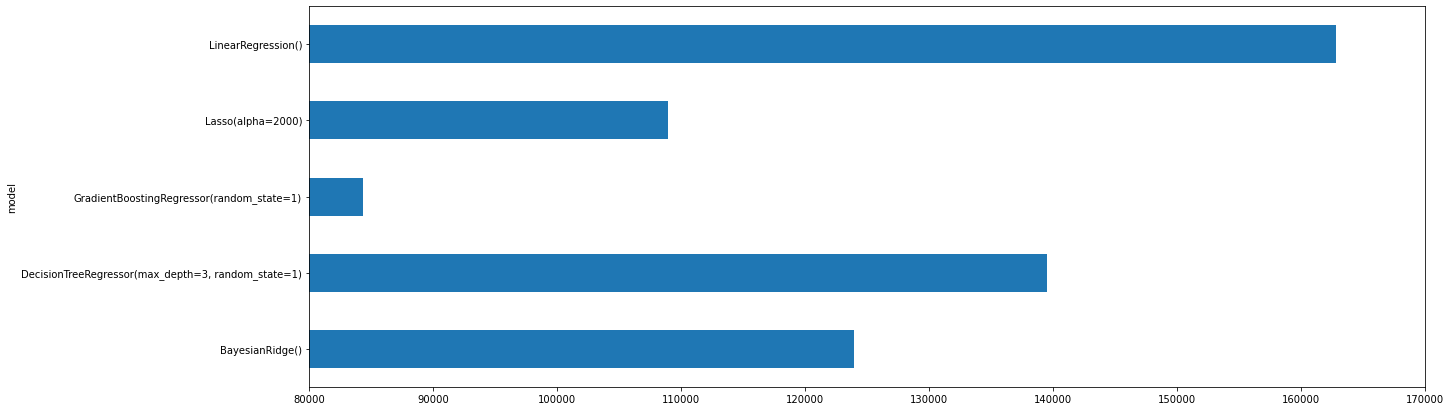

In [243]:
plt.figure(figsize=(20,7))
df_summary['model'] = df_summary['model'].astype(str)

df_summary_grouped_model = df_summary.groupby(['model'])["mae"].mean()
ax = df_summary_grouped_model.plot.barh(x='model', y='mae')
plt.xlim([80000, 170000])
plt.show()

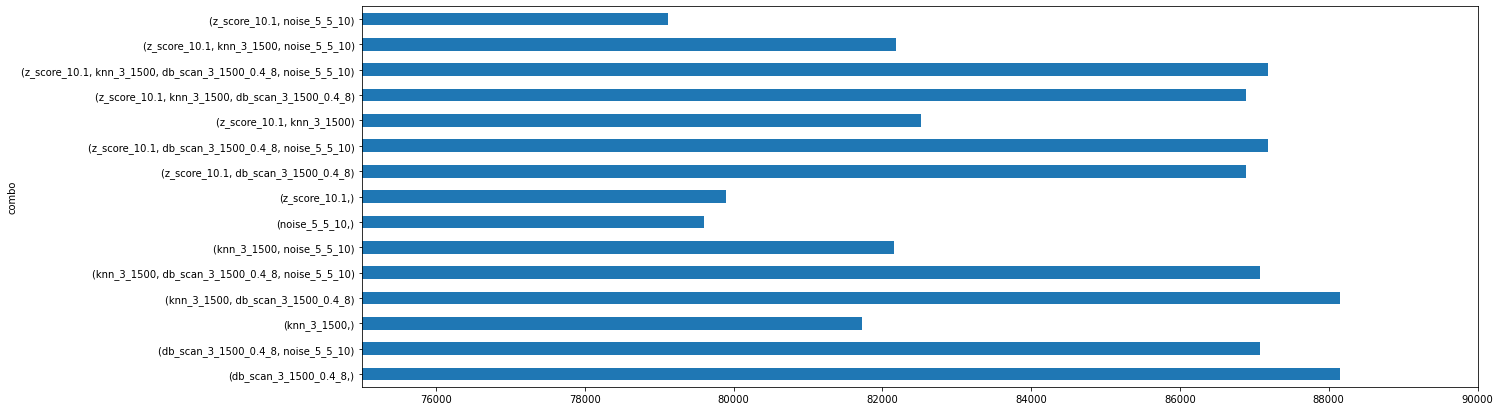

In [244]:
plt.figure(figsize=(20,7))
df_summary_grouped_model = df_summary.groupby(['combo'])["mae"].min()
ax = df_summary_grouped_model.plot.barh(x='combo', y='mae')
plt.xlim([75000, 90000])
plt.show()

In [245]:
mae_best = df_summary[df_summary.mae==df_summary.mae.min()]
best_model_obj = getBestModel(model_obj_list, df_summary, mae_best.index[0])
print(best_model_obj)

Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 24


## Feature Selection

### By Correlation

In [246]:
model_obj_list_best = [best_model_obj]
X_train, X_test, y_train, y_test = best_model_obj.get_data()

df_feature_reduction = train_test_to_df(X_train, X_test, y_train, y_test, best_model_obj.get_features())

for threshold in FEATURE_SEL_CORR["THRESHOLD_CORR"]:
    try: 
        rel_features = getRelFeatures(df_feature_reduction, threshold)
        df_feature_reduction = df_feature_reduction[rel_features]
        X_train, X_test, y_train, y_test = splitData(df_feature_reduction, SPLIT_SIZE)
        comb = best_model_obj.get_comb()
        best_model_obj_new = Model(best_model_obj.get_model(), (X_train, X_test, y_train, y_test), comb , df_feature_reduction, df_feature_reduction.columns.to_list())
        model_obj_list_best.append(best_model_obj_new)

    except Exception as e:
        print(bold("Error"), red(e))

for m in model_obj_list_best:
    print(m)

Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 24
Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 11
Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 9


### Manual

In [247]:
# model_obj_list_best = [best_model_obj]
if FEATURE_SEL_MANUAL == True:
    X_train, X_test, y_train, y_test = best_model_obj.get_data()

    df_feature_reduction_manual = train_test_to_df(X_train, X_test, y_train, y_test, best_model_obj.get_features())

    rel_features = [
    'price',
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'waterfront',
    'view',
    'condition',
    'grade',
    'sqft_above',
    'sqft_basement',
    'yr_built',
    'lat',
    'long',
    'sqft_living15',
    'sqft_lot15',
    'ahf1',
    'ahf2',
    'ahf3']

    #'yr_renovated',
    #'zipcode',
    #'date'
    #'id'

    df_feature_reduction_manual = df_feature_reduction_manual[rel_features]
    X_train, X_test, y_train, y_test = splitData(df_feature_reduction_manual, SPLIT_SIZE)
    comb = best_model_obj.get_comb()
    best_model_obj_new = Model(best_model_obj.get_model(), (X_train, X_test, y_train, y_test), comb , df_feature_reduction_manual, df_feature_reduction_manual.columns.to_list())
    model_obj_list_best.append(best_model_obj_new)

    for m in model_obj_list_best:
        print(m)

Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 24
Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 11
Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 9
Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 20


### Feature Slection Summary

In [248]:
df_summary_best = pd.DataFrame(columns=['model', 'combo', 'mae', 'score', 'features'])
for o in model_obj_list_best:
    o.train()
    mae, score = o.summary()
    comb = o.get_comb()
    features = o.get_features()
    if "price" in features:
        features.remove("price")
    row = {'model': "GradientBoostingRegressor(random_state=1)",'combo': comb, 'mae': mae, 'score': score, 'features': len(features)}
    df_summary_best = df_summary_best.append(row, ignore_index=True)

In [249]:
df_summary_best.sort_values("mae")

,model,combo,mae,score,features
0,GradientBoostingRegressor(random_state=1),"(z_score_10.1, noise_5_5_10)",79124.14,0.86054,23
3,GradientBoostingRegressor(random_state=1),"(z_score_10.1, noise_5_5_10)",82045.92,0.858956,19
1,GradientBoostingRegressor(random_state=1),"(z_score_10.1, noise_5_5_10)",95721.52,0.814615,10
2,GradientBoostingRegressor(random_state=1),"(z_score_10.1, noise_5_5_10)",100136.7,0.794204,8


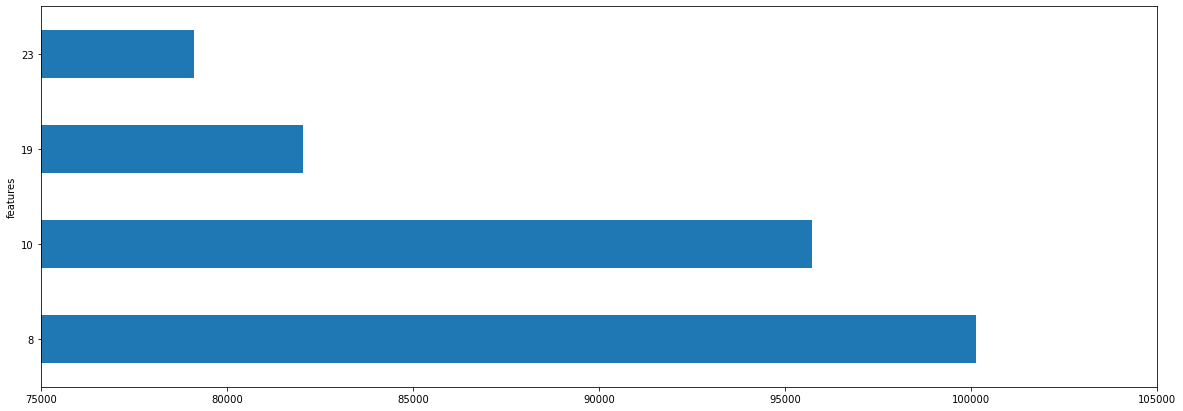

In [250]:
plt.figure(figsize=(20,7))
df_summary_grouped_model = df_summary_best.groupby(['features'])["mae"].min()
ax = df_summary_grouped_model.plot.barh(x='combo', y='mae')
plt.xlim([75000, 105000])
plt.show()

## Select Best Model
Saving the best prediction model into a Pickle File

In [251]:
saveModel(model_obj_list_best[0])
loaded_object = loadModel()

Model: GradientBoostingRegressor(random_state=1) Combination: ('z_score_10.1', 'noise_5_5_10') Features: 23


## Visualize

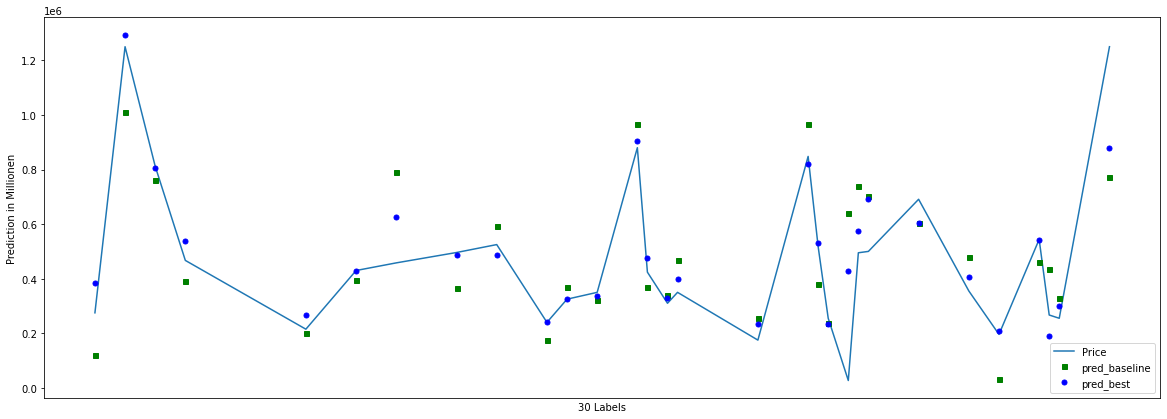

In [252]:
#Best Model
df_baseline = X_test_base
df_best = X_test_base[loaded_object.get_features()]
loaded_object.train()
reg_best = loaded_object.get_model()

pre_best = reg_best.predict(df_best)

df_baseline["price"] = y_test_base.values
df_baseline

df_baseline["pred_best"] = pre_best
df_baseline["diff_best"] = df_baseline["price"] - df_baseline["pred_best"]  

#baseline Model

df_baseline["pred_base"] = ypred_base
df_baseline["diff_base"] = df_baseline["price"] - df_baseline["pred_base"]  

plt.figure(figsize=(20,7))
#Prediction der Modelle für die ersten 20 Zeilen
x = 150
w = 120
df_baseline = df_baseline.sort_index(ascending=True)
real = df_baseline.iloc[w:x, df_baseline.columns.get_loc("price")]
pred_base = df_baseline.iloc[w:x, df_baseline.columns.get_loc("pred_base")]
diff_base = df_baseline.iloc[w:x, df_baseline.columns.get_loc("diff_base")]
pred_best = df_baseline.iloc[w:x, df_baseline.columns.get_loc("pred_best")]
diff_best = df_baseline.iloc[w:x, df_baseline.columns.get_loc("diff_best")]

plt.plot(real, label="Price")
plt.plot(pred_base, "gs", ms=5, label="pred_baseline")
#plt.plot(diff_base, "gs", ms=5, label="diff_baseline")
plt.plot(pred_best, "bo", ms=5, label="pred_best")
#plt.plot(diff_best, "bo", ms=5, label="diff_best")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Prediction in Millionen")
plt.xlabel("30 Labels")
plt.legend(loc="best")

plt.show()

In [253]:
print(loaded_object.summary()[0])
print(np.round(mae_base), 2)


79124.14
128811.0 2
